Workflow:

1) Check if data has null

2) Feature engineering with insights

3) Oversample

4) Build first model

5) Assess

6) Feature engineer and selection

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


In [4]:
train.info()
#dataset only has one null cell

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2402 entries, 0 to 2401
Data columns (total 13 columns):
id                2402 non-null int64
industry          2401 non-null object
state             2402 non-null object
request_date      2402 non-null object
term              2402 non-null int64
employee_count    2402 non-null int64
business_new      2402 non-null object
business_type     2402 non-null int64
location          2402 non-null object
other_loans       2402 non-null object
loan_amount       2402 non-null object
insured_amount    2402 non-null object
default_status    2402 non-null int64
dtypes: int64(5), object(8)
memory usage: 244.0+ KB


In [5]:
#check count of default_status incidence, might need to over or under sample
train.default_status.value_counts()

0    1629
1     773
Name: default_status, dtype: int64

In [6]:
train['request_date'] = pd.to_datetime(train['request_date'])

### EDA

In [7]:
train.industry.value_counts()

Trading           508
Construction      275
Consulting        267
Manufacturing     245
Hotel             245
Healthcare        219
Others            168
Administration    125
Transportation    106
Agriculture        58
Real Estate        44
Engineering        40
Finance            32
Entertainment      31
Education          29
Energy              9
Name: industry, dtype: int64

In [8]:
train.state.value_counts()

CA    293
TX    191
NY    133
OH    102
FL     95
MN     91
WI     80
IL     79
UT     77
MA     74
MO     69
WA     62
CO     60
PA     59
AZ     55
IN     53
MI     51
NC     47
GA     43
IA     42
VA     40
OR     37
MS     36
KY     34
KS     33
NJ     29
OK     29
NE     29
TN     28
NH     28
LA     28
MT     27
CT     27
MD     26
ID     26
ME     20
AL     20
NV     18
VT     17
NM     16
ND     15
HI     14
SD     14
RI     14
SC     12
AR     11
WV      7
WY      5
DE      4
AK      2
Name: state, dtype: int64

In [9]:
train.business_new.value_counts()

New         1687
Existing     715
Name: business_new, dtype: int64

In [10]:
train.location.value_counts()

Rural    2402
Name: location, dtype: int64

In [11]:
train.columns

Index(['id', 'industry', 'state', 'request_date', 'term', 'employee_count',
       'business_new', 'business_type', 'location', 'other_loans',
       'loan_amount', 'insured_amount', 'default_status'],
      dtype='object')

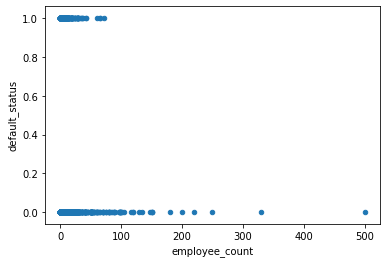

In [12]:
train.plot(kind='scatter', x='employee_count',y='default_status')

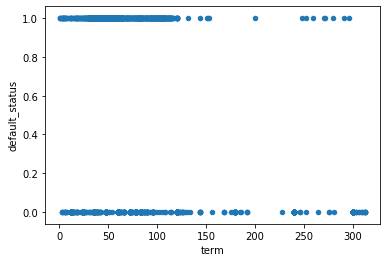

In [13]:
train.plot(kind='scatter', x='term',y='default_status')

### Feature Engineering

id - remove for model
industry - one hot encoding?
state - 
request_date - 
insured / loan amount are highly correlated - might want to drop one of them

In [14]:
### data-cleaning & exploratory feature engineering

def data_clean(df):
    df['other_loans'] = df['other_loans'].replace('Y', 1)
    df['other_loans'] = df['other_loans'].replace('N', 0)
    
    df['business_new'] = df['business_new'].replace('New', 1)
    df['business_new'] = df['business_new'].replace('Existing', 0)
    
    df['loan_amount'] = df['loan_amount'].replace('[\$,]', '', regex=True).astype(float)
    df['insured_amount'] = df['insured_amount'].replace('[\$,]', '', regex=True).astype(float)
    df['uninsured_amount'] = df['loan_amount'] - df['insured_amount']

    #drop columns for model
    #location is removed because it is all rural in both train & test set
    df.drop(columns=['request_date','state','location','insured_amount'], inplace=True)

In [15]:
data_clean(train)

In [16]:
train = pd.concat([train, pd.get_dummies(train['industry'],drop_first=True,prefix="industry")],axis=1)
train.drop(columns=['industry'], inplace=True)

In [17]:
train.drop(columns=['industry_Entertainment', 'industry_Finance'], inplace=True)

In [18]:
train.head()

,id,term,employee_count,business_new,business_type,other_loans,loan_amount,default_status,uninsured_amount,industry_Agriculture,...,industry_Education,industry_Energy,industry_Engineering,industry_Healthcare,industry_Hotel,industry_Manufacturing,industry_Others,industry_Real Estate,industry_Trading,industry_Transportation
0,4050975007,34,4,1,0,0,35000.0,1,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,3735095001,107,1,1,0,0,15000.0,1,1500.0,0,...,0,0,0,0,0,1,0,0,0,0
2,3936555004,84,1,1,0,1,265000.0,0,165000.0,0,...,0,0,0,0,0,0,0,0,1,0
3,4130405000,240,21,1,0,0,255000.0,0,0.0,0,...,0,0,1,0,0,0,0,0,0,0
4,4263615008,36,1,0,0,0,13300.0,0,6650.0,0,...,1,0,0,0,0,0,0,0,0,0


### Model

In [19]:
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss

Using TensorFlow backend.


In [20]:
X1, y1 = train.drop(columns=['default_status','id']), train['default_status']

from imblearn.over_sampling import ADASYN
X, y = ADASYN(random_state=42).fit_sample(X1,y1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [21]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

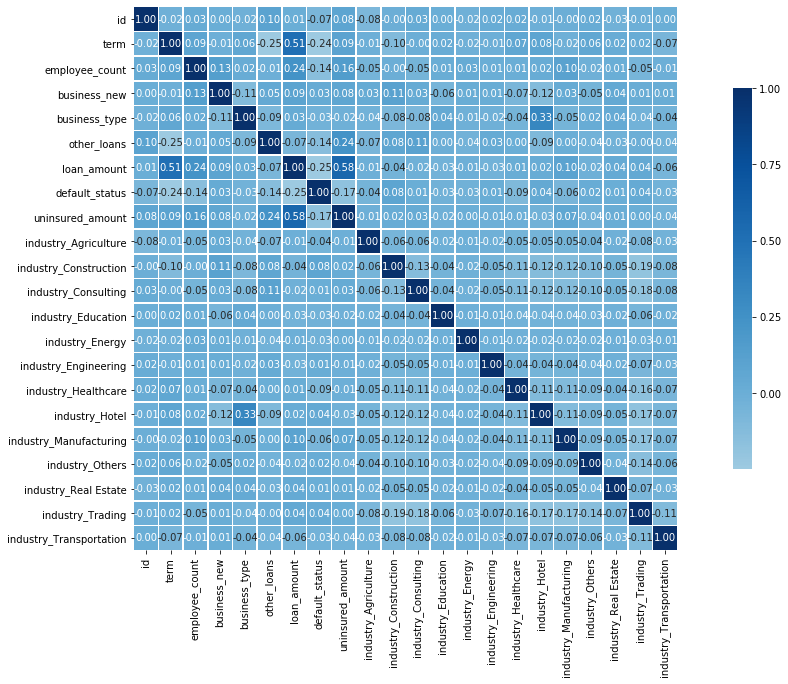

In [22]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, cmap='Blues')
    plt.show();
    
correlation_heatmap(train)

#loan amount and insured amount were closely correlated in the first round

### Random Forest

In [23]:
%time

forest = RandomForestClassifier(n_estimators=100, max_depth=7, max_features=12)
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

print("The score for Random Forest is")
print("Training: {:6.2f}%".format(100*forest.score(X_train, y_train)))
print("Validate: {:6.2f}%".format(100*forest.score(X_val, y_val)))
print("Log-loss: {:6.4f}".format(log_loss(y_val, forest.predict_proba(X_val))))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11 µs
The score for Random Forest is
Training:  95.41%
Validate:  90.74%
Log-loss: 0.2511


In [24]:
forest_pred = forest.predict(X_val)
print('Forest Results:')
print(confusion_matrix(y_val, forest_pred))
print(classification_report(y_val, forest_pred))
forest_score = forest.fit(X_train, y_train).score(X_val, y_val)

Forest Results:
[[338  46]
 [ 30 407]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       384
           1       0.90      0.93      0.91       437

    accuracy                           0.91       821
   macro avg       0.91      0.91      0.91       821
weighted avg       0.91      0.91      0.91       821



In [25]:
forest_pred = forest.predict(X_val)

accuracy = accuracy_score(y_val, forest_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 91.3520097442%


### Parameters Tuning - Forest

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
est = RandomForestClassifier()

rf_p_dist = {
     "n_estimators"    : [10,50,100,200,500] ,
     "max_depth"  : range(1,12),
     "max_features" : (3,6,9,12),
     "min_samples_split" : (2,4,8)
     }

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [28]:
hypertuning_rscv(est, rf_p_dist, 3, X, y)

#this results changes everytime code is ran. So I selected the one that works the best

({'n_estimators': 50,
  'min_samples_split': 8,
  'max_features': 12,
  'max_depth': 6},
 0.8954587016153611)

### Logistic Regression

In [29]:
%time

logistic = LogisticRegression(penalty='l1', C=10, max_iter=100)
logistic.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logistic.score(X_train, y_train)))
print("Validate: {:6.2f}%".format(100*logistic.score(X_val, y_val)))
print("Log-loss: {:6.4f}".format(log_loss(y_val, logistic.predict_proba(X_val))))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 14.1 µs
The score for logistic regression is
Training:  68.50%
Validate:  70.89%
Log-loss: 0.5979


/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
logistic_pred = logistic.predict(X_val)
print('Logistic Results:')
print(confusion_matrix(y_val,logistic_pred))
print(classification_report(y_val, logistic_pred))

Logistic Results:
[[254 130]
 [109 328]]
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       384
           1       0.72      0.75      0.73       437

    accuracy                           0.71       821
   macro avg       0.71      0.71      0.71       821
weighted avg       0.71      0.71      0.71       821



In [31]:
logistic_y_score = logistic.predict_proba(X_val)[:, 1]

#calculate roc curve
logistic_fpr, logistic_tpr, logistic_auc_thresholds = roc_curve(y_val, logistic_y_score)

#calculate auc
auc_logistic = roc_auc_score(y_val, logistic_y_score)
print('ROC_AUC: %.3f' % (auc_logistic*100))

ROC_AUC: 74.412


In [32]:
logistic_pred = logistic.predict(X_val)

accuracy = accuracy_score(y_val, logistic_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 70.8891595615%


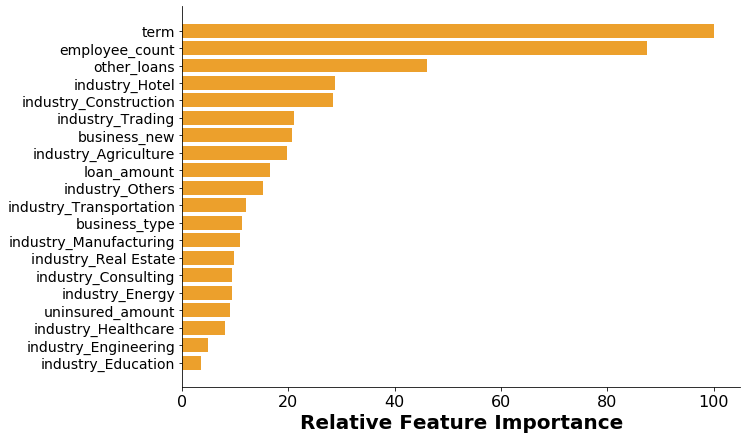

In [33]:
feature_importance = abs(logistic.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(1,figsize=(10,7))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#eca02c')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X1.columns)[sorted_idx], fontsize=14)

featax.set_xlabel('Relative Feature Importance', fontsize=20, weight='bold')
featax.tick_params(axis="x", labelsize=16)


featax.spines['right'].set_visible(False)
featax.spines['top'].set_visible(False)
featax.spines['bottom'].set_visible(True)
featax.spines['left'].set_visible(True)

featax.patch.set_visible(False)

# plt.savefig('feature_importance.jpg', transparent=True);
# plt.show()


### Tuning parameters - Logistic Regression

In [34]:
est = LogisticRegression()

rf_p_dist = {
     "C"    : [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
     "penalty"  : [ 'l1','l2'],
     "max_iter" : [ 50,100,150 ],
     "fit_intercept": ['True','False']
     }

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [35]:
hypertuning_rscv(est, rf_p_dist, 5, X, y)

/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


({'penalty': 'l1', 'max_iter': 150, 'fit_intercept': 'True', 'C': 1000},
 0.6918622371228285)

### Find Threshold for Prediction

In [36]:
from sklearn import metrics

In [37]:
predictions = forest.predict_proba(X_val)[:,1]

#### Using Precision-Recall Curve

Text(0, 0.5, '%')

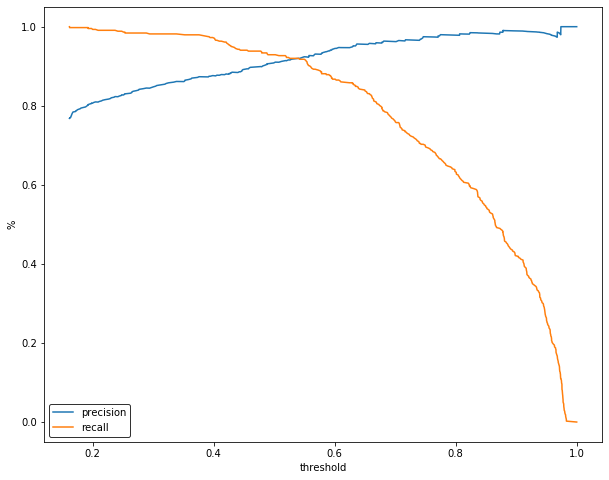

In [38]:
precision, recall, thresholds = precision_recall_curve(y_val, predictions) 
thresholds = np.append(thresholds, 1) 

plt.figure(figsize=(10,8))    
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1])  

leg = plt.legend(('precision', 'recall'), frameon=True) 
leg.get_frame().set_edgecolor('k') 

plt.xlabel('threshold') 
plt.ylabel('%')

### Import Test Data for Predictions

In [39]:
test = pd.read_csv('test.csv')

In [40]:
test.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount
0,3999155010,Hotel,CA,26-Mar-10,91,1,Existing,1,Rural,N,"$270,000.00","$243,000.00"
1,4035035009,Hotel,WA,19-Apr-10,124,0,Existing,0,Rural,N,"$443,574.00","$432,000.00"
2,3889475000,Construction,NY,04-Feb-10,60,5,New,0,Rural,N,"$30,000.00","$15,000.00"
3,3794845001,Transportation,ME,04-Dec-09,29,8,New,0,Rural,Y,"$340,000.00","$75,000.00"
4,4163475006,Hotel,CO,12-Jul-10,84,2,Existing,0,Rural,Y,"$150,000.00","$127,500.00"


In [41]:
data_clean(test)

In [42]:
test = pd.concat([test, pd.get_dummies(test['industry'],drop_first=True,prefix="industry")],axis=1)
test.drop(columns=['industry'], inplace=True)

In [43]:
test.drop(columns=['industry_Entertainment', 'industry_Finance'], inplace=True)

In [44]:
test.head()

,id,term,employee_count,business_new,business_type,other_loans,loan_amount,uninsured_amount,industry_Agriculture,industry_Construction,...,industry_Education,industry_Energy,industry_Engineering,industry_Healthcare,industry_Hotel,industry_Manufacturing,industry_Others,industry_Real Estate,industry_Trading,industry_Transportation
0,3999155010,91,1,0,1,0,270000.0,27000.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4035035009,124,0,0,0,0,443574.0,11574.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3889475000,60,5,1,0,0,30000.0,15000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3794845001,29,8,1,0,1,340000.0,265000.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4163475006,84,2,0,0,1,150000.0,22500.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [45]:
X_test = test.drop('id',axis=1)

In [46]:
threshold = 0.55

predicted_proba = forest.predict_proba(X_test)
predicted = (predicted_proba [:,1] <= threshold).astype('int')
test['default_status'] = predicted

In [47]:
submissions = test[['id','default_status']] 

In [49]:
submissions.to_csv('submissions_kelseyheng.csv')

### Conclusion

#### Logistic Regression VS Random Forest:

Random forest has a higher accuracy, overfitting has been minimized. As the dataset expands in production, random forest will have a significantly higher time complexity than logistic regression. These two models have different pros and cons depending on the business need.

#### Insights from the data

Term of loan: 
No. of employers:
Different industry:
Other loans:
